In [7]:
import generalized_rashomon_set as grs
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, TensorDataset
import torch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from src.Utilities import load_data, m_training_process_vis, plot_feature_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns; sns.set()
from train_nn_categorical_descriptor import Net_mx_descriptor
sns.set(color_codes=True)
sns.set(font_scale=1.2)
#plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Conventional workflow
### Load data from csv file

In [2]:
X_df = load_data(filename='../data/data_withLattice.csv')
X_features = X_df.iloc[:,1:-5]
feature_names = X_features.columns.values

y_multilabel = X_df.iloc[:,-5:]
label_names = y_multilabel.columns.values

print('Feature names: \n', feature_names)
print('Label names: ', label_names)

Feature names: 
 ['Sc' 'Ti' 'V' 'Cr' 'Zr' 'Nb' 'Mo' 'Hf' 'Ta' 'C' 'N' 'F' 'H' 'O' 'OH'
 'NULL' 'Li' 'Na' 'K' 'Mg']
Label names:  ['Voltage(V)' 'Theoretical_capacity (mAh/g)' 'Induced_Z_charge(mAh/g)'
 'In-plane lattice' 'In-plane lattice(intercalated)']


## Categorical descriptor

In [3]:
X = X_features.to_numpy()
y = y_multilabel.to_numpy()
scaler = preprocessing.MinMaxScaler()
y = scaler.fit_transform(y)

In [4]:
data_index = []
for index, row in X_features.iterrows():
    indices = [i for i, x in enumerate(row) if x == 1]
    indices[1] = indices[1] - 9
    indices[2] = indices[2] - 11
    indices[3] = indices[3] - 16
    data_index.append(indices)
X_features_classes = np.array(data_index)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_features_classes, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.9, train_size=0.1, random_state=42)

In [6]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [8]:
model = Net_mx_descriptor()
model.load_state_dict(torch.load('../results/model/best_model_ANN_mx_descriptor.pth'))
model.eval()

Net_mx_descriptor(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [33]:
print('The MSE loss of trained NN on the test set is {}, MAE is {}, R2 is {}, training process is illustrated below'.format(mean_squared_error(y_test, model(X_test_tensor).detach().numpy()), mean_absolute_error(y_test, model(X_test_tensor).detach().numpy()), r2_score(y_test, model(X_test_tensor).detach().numpy())))
print('The R2 of trained NN on the training set is {}'.format(r2_score(y_train, model(X_train_tensor).detach().numpy())))

The MSE loss of trained NN on the test set is 0.005181678689038515, MAE is 0.0460608965637659, R2 is 0.8598365828992817, training process is illustrated below
The R2 of trained NN on the training set is 0.9876090678371492


## Training process

In [10]:
train_loss = np.load('../results/model/train_loss_mx_descriptor.npy')
test_loss = np.load('../results/model/test_loss_mx_descriptor.npy')

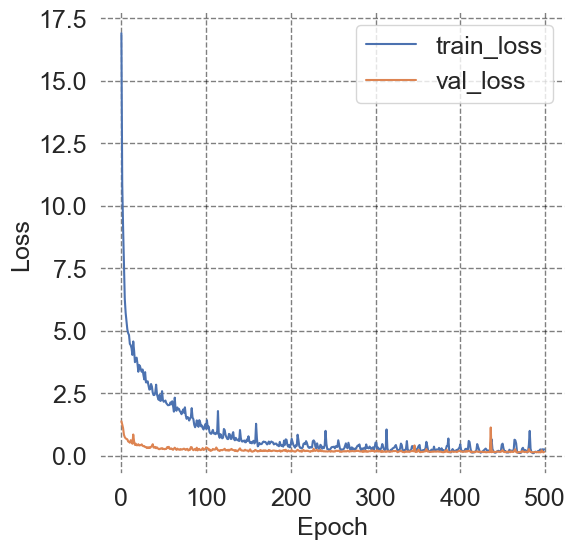

In [11]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.plot(train_loss[:], label='train_loss')
ax.plot(test_loss[:], label='val_loss')
ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(bbox_to_anchor=(1.0, 1.0), shadow=False, facecolor='white', fontsize=18)
ax.set_xlabel('Epoch',fontsize=18)
ax.set_ylabel('Loss',fontsize=18)
plt.savefig('../results/figs/training_process_mx_descriptor.png', bbox_inches='tight')
plt.show()

In [12]:
pred_train = model(X_train_tensor).detach().numpy()
pred_test = model(X_test_tensor).detach().numpy()

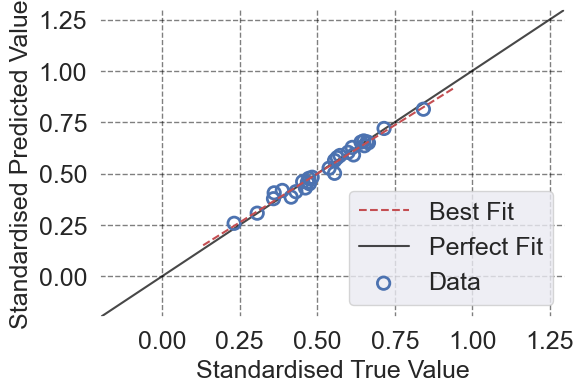

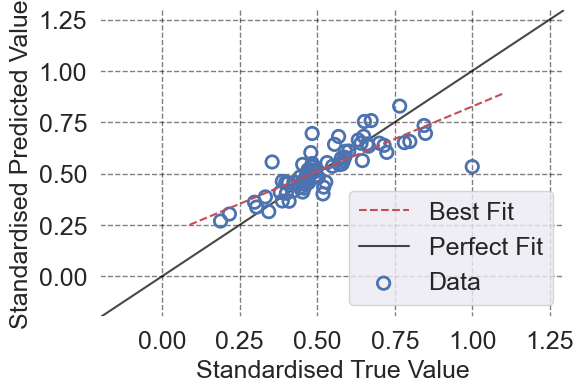

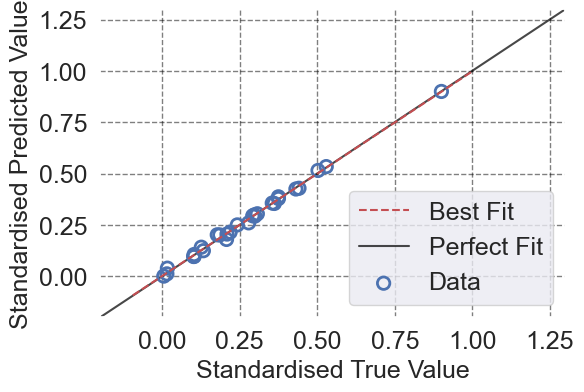

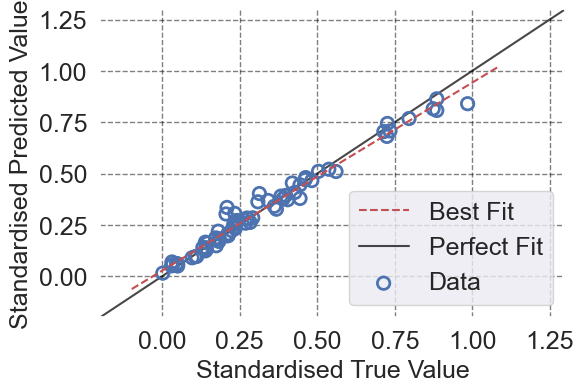

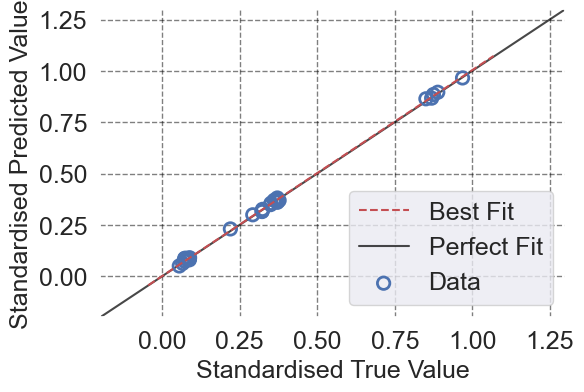

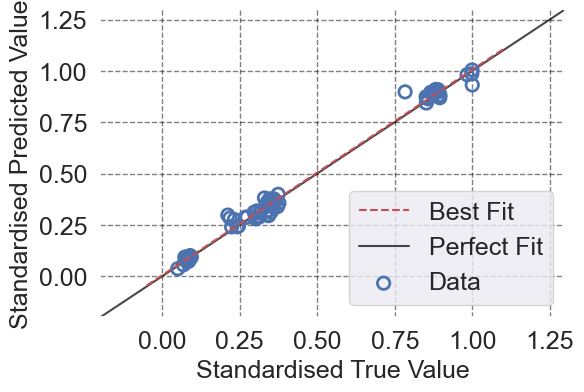

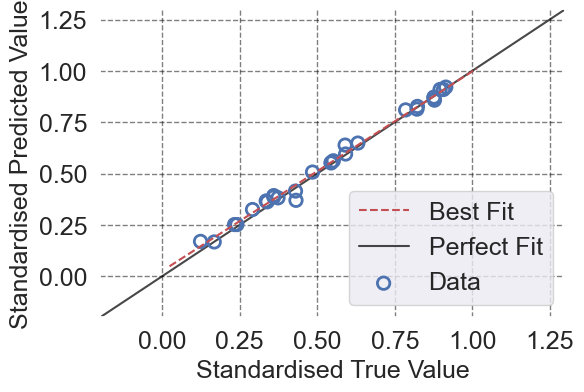

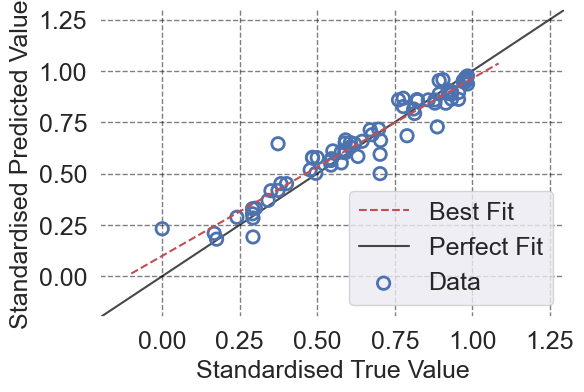

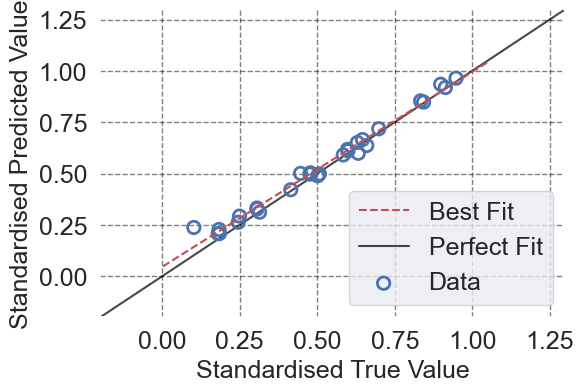

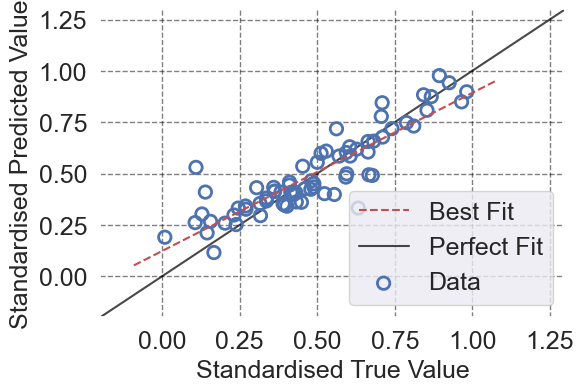

In [13]:
from src.Utilities import plot_gth_pre
for idx, label in enumerate(label_names):
    range_max = 1.3
    range_min = -0.2
    plot_gth_pre(y_train[:, idx], pred_train[:, idx], range_set=False, range_x=[range_min,range_max], range_y=[range_min,range_max],
                 tag='_Train_mx'+label[:20])
    plot_gth_pre(y_test[:, idx], pred_test[:, idx], range_set=False, range_x=[range_min,range_max], range_y=[range_min,range_max],
                 tag='_Test_mx'+label[:20])

## PCA results (ground truth vs predictions)

In [14]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)
z_nn = pca.fit_transform(y_test)
z_pred_nn = pca.fit_transform((model(X_test_tensor).detach().numpy()))

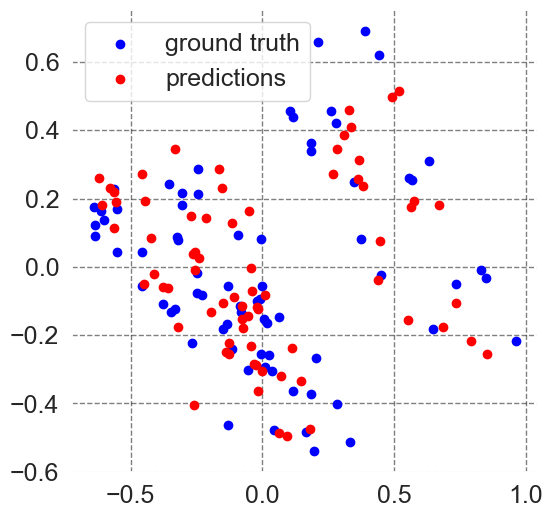

In [16]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.scatter(z_nn[:,0], z_nn[:,1], color='blue', label='ground truth')
ax.scatter(z_pred_nn[:,0], z_pred_nn[:,1], color='red', label='predictions')
# ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
# ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(loc=2, shadow=False, facecolor='white', fontsize=18)
# ax.set_xlabel('PCA',fontsize=18)
plt.savefig('../results/figs/pred_vs_gth_nn_cat.png', bbox_inches='tight')
plt.show()

## Sample from the Rashomon set

In [17]:
import os
ROOT_DIR = os.getcwd()
OUTPUT_DIR = ROOT_DIR+'/../results'

In [18]:
fis_explainer_mlp = grs.explainers.fis_explainer(model, X_test, y_test, epsilon_rate=0.1, loss_fn='regression', wrapper_for_torch=True)

2023-09-04 15:45:10,377 INFO _explainer __init__ You can call function explainer.load_results(results_path="") to load trained results if exist


In [19]:
fis_explainer_mlp.ref_explain()

2023-09-04 15:47:00,906 INFO _explainer ref_explain Reference model analysis
2023-09-04 15:47:00,906 INFO _explainer ref_explain Calculating main effect, joint effect and FIS for the reference model
2023-09-04 15:47:00,951 INFO _explainer ref_explain main effects calculated and can be called by explainer.ref_analysis[ref_main_effects]
2023-09-04 15:47:00,952 INFO _explainer ref_explain features with importance 0 are excluded, including []
2023-09-04 15:47:01,016 INFO _explainer _get_ref_fis joint effects calculated and can be called by explainer.ref_joint_effects
2023-09-04 15:47:01,016 INFO _explainer ref_explain FIS calculated and can be called by explainer.ref_analysis
2023-09-04 15:47:01,017 INFO _explainer ref_explain Calculation done


In [20]:
fis_explainer_mlp.rset_explain()

2023-09-04 15:47:01,960 INFO _explainer rset_explain Start exploring the possible models
2023-09-04 15:47:01,961 INFO _explainer _explore_m_in_R Searching models in the Rashomon set ...
2023-09-04 15:47:01,962 INFO _general_utils greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-09-04 15:47:01,963 INFO _general_utils greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-09-04 15:47:01,964 INFO _general_utils greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-09-04 15:47:01,965 INFO _general_utils greedy_search Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss difference 0.0
2023-09-04 15:47:01,976 INFO _general_utils greedy_search Feature 0 at boundary 0.1 * epsilon with m 1.1 achieves loss difference 0.0
2023-09-04 15:47:01,977 INFO _general_utils greedy_search Feature 0 at boundary 0.1 * epsilon with m 1.1 achieves loss difference 0.012889781359013523
2

## Feature importance from the sampled Rashonmon set

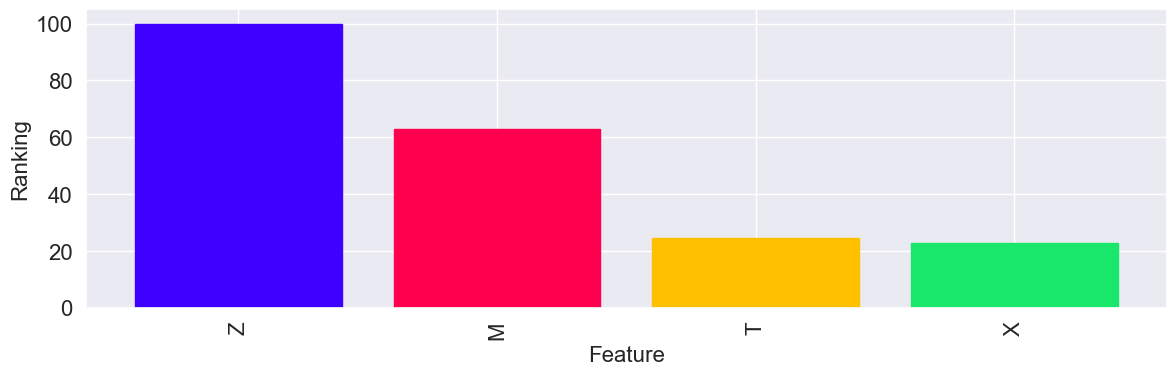

In [30]:
X_features_names = ['M', 'X', 'T', 'Z']
plot_feature_importance(
    X_features_names,
    fis_explainer_mlp.feature_importance_uni(std=True),
    show_cols = 20
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# plt.savefig('../results/figs/feature_importance_nn_cat.png', dpi = 300, bbox_inches='tight')
plt.show()

## save results in a table

In [31]:
results_csv = np.zeros((4, 4))
for idx,i in enumerate(np.array(fis_explainer_mlp.rset_main_effect_processed['all_main_effects_diff']).transpose(
        (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))):
    results_csv[idx, 0] = np.average(i)
    results_csv[idx, 1] = np.min(i)
    results_csv[idx, 2] = np.max(i)
    results_csv[idx, 3] = np.std(i)
results_csv

array([[0.03811549, 0.03613123, 0.0398978 , 0.00073196],
       [0.00405077, 0.00338994, 0.00481429, 0.00026696],
       [0.01006048, 0.00943612, 0.0109172 , 0.00028781],
       [0.05803551, 0.05506102, 0.06104632, 0.00116516]])

In [ ]:
## utilities for categorical descriptor
from copy import copy
import matplotlib.colors as mcolors
import colorsys
def colors_vis(c, lightness=0.5):
    default_colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF"]
    rgb_color = mcolors.hex2color(default_colors[c])
    # Convert RGB color to HSL color
    hls_color = colorsys.rgb_to_hls(*rgb_color)
    # Adjust lightness value
    hls_color_adjusted = (hls_color[0], lightness, hls_color[2])
    # Convert HSL color back to RGB color
    rgb_color_adjusted = colorsys.hls_to_rgb(*hls_color_adjusted)
    return rgb_color_adjusted
def plot_feature_importance(ft_set, feature_importance, show_cols = 30):

    fig = plt.figure(figsize=(12,4))
    w_lr_sort, ft_sorted, sorted_index_pos = return_feature_importance(ft_set, feature_importance, show_cols = show_cols)
    x_val = list(range(len(w_lr_sort)))
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    barlist=plt.bar(x_val, w_lr_sort)
    barlist[0].set_color(colors_vis(c=3))
    barlist[1].set_color(colors_vis(c=1))
    barlist[2].set_color(colors_vis(c=4))
    barlist[3].set_color(colors_vis(c=2))
    plt.xlabel('Feature', fontsize=16)
    plt.ylabel('Ranking', fontsize=16)
    plt.xticks(x_val, ft_sorted, rotation='vertical')

    return fig
def return_feature_importance(ft_set, feature_importance, show_cols = 30):

    w_lr = copy(np.abs(feature_importance))
    w_lr = 100 * (w_lr / w_lr.max())
    sorted_index_pos = [index for index, num in sorted(enumerate(w_lr), key=lambda x: x[-1],
                   reverse=True)]

    ft_sorted = []
    w_lr_sort = []
    for i, idx in enumerate(sorted_index_pos):
        if i > show_cols:
            break
        ft_sorted.append(ft_set[idx])
        w_lr_sort.append(w_lr[idx])

    return w_lr_sort, ft_sorted, sorted_index_pos